In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib qt5

In [2]:
df = pd.read_csv("./data/daily-min-temperatures.csv")
df['Date'] = pd.to_datetime(df['Date'])
df.index = pd.DatetimeIndex(df['Date'])
df.head()

,Date,Temp
Date,,
1981-01-01,1981-01-01,20.7
1981-01-02,1981-01-02,17.9
1981-01-03,1981-01-03,18.8
1981-01-04,1981-01-04,14.6
1981-01-05,1981-01-05,15.8


In [3]:
fig, fax = plt.subplots()
fax.plot(df['Temp'], marker='.', ms=0.1)
fax.plot(df['Temp'].resample('M').mean())
fax.plot(df['Temp'].resample('Y').mean())

In [4]:
fig, fax = plt.subplots()
fax.plot(df['Temp'].rolling(window='30D').mean())
fax.plot(df['Temp'].rolling(window='30D').std())

In [5]:
y = df['Temp']
fig, fax = plt.subplots()
fax.plot((y - y.rolling(window='30D').mean()) / y.rolling(window='30D').std())

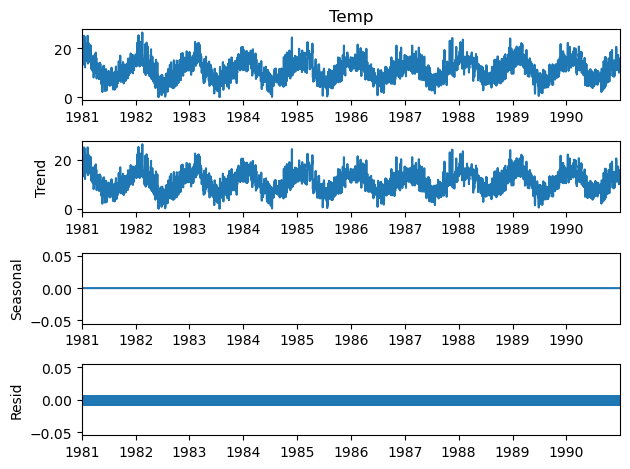

In [27]:
import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(df['Temp'], model='additive', extrapolate_trend='freq', period=1)
decomposition.plot()

In [20]:
from statsmodels.tsa.api import SimpleExpSmoothing

y_to_train = y[:-300]

fit = SimpleExpSmoothing(y_to_train).fit()
fcast = fit.forecast(50)
fig, fax = plt.subplots()
fax.plot(y_to_train[-300:-250].to_numpy())
fax.plot(fcast.to_numpy())

/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [21]:
from statsmodels.tsa.api import Holt

y_to_train = y[:-300]

fit = Holt(y_to_train).fit()
fcast = fit.forecast(50)
fig, fax = plt.subplots()
fax.plot(y_to_train[-300:-250].to_numpy())
fax.plot(fcast.to_numpy())

/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [28]:
from statsmodels.tsa.api import ExponentialSmoothing

y_to_train = y[:-300]

fit = ExponentialSmoothing(y_to_train, seasonal_periods=12, trend='add', seasonal='add').fit()
fcast = fit.forecast(50)
fig, fax = plt.subplots()
fax.plot(y.to_numpy())
fax.plot(fcast)

/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/home/kirill/opt/miniconda/envs/kaggle/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
